In [1]:
import numpy as np
from functools import reduce
import matplotlib.pyplot as plt

In [2]:
def conv_enc(u,g,m) :
    codebits = np.array([])
    mem = np.array([])
    c = np.array([])
    for i in range(m):
        mem = np.append(mem,0)
    for i in range(u.size):
        mem = np.append(mem,u[i])
        if i!=0 : mem = mem[1:]
        for _ in g:
            c = np.append(c,reduce(lambda x,y: x^y, np.logical_and(_,mem) ) )
        codebits = np.append(codebits,c)
        c = np.array([])
    return np.resize(codebits,(u.size,g.shape[0]))

In [3]:
class state_table_class :
    def __init__(self,prev_state,outp,inp):
        self.prev_state=prev_state
        self.outp=outp
        self.inp=inp

In [4]:
def conv_dec(d_in,state_table,debug=False):
    accumulative_metric = np.zeros(state_table.outp.shape[1],dtype=int)
    accumulative_metric_nxt = np.zeros(state_table.outp.shape[1],dtype=int)
    path_matrix_entry = np.zeros(state_table.outp.shape[1],dtype=int)
    path_matrix = np.array([])
    message_size = d_in.shape[0]
    for k in range(message_size):      
        for j in range(state_table.outp.shape[1]):
            for i in range(state_table.outp.shape[0]):
                branch_metrics = np.logical_xor(d_in[k],state_table.outp[i][j]).sum()   #calculate branch metrics
                if i==0:
                    min_path = state_table.prev_state[0][j]
                    min_bm = branch_metrics + accumulative_metric[min_path] #Add
                else :
                    current_path = state_table.prev_state[i][j]
                    current_bm = branch_metrics+accumulative_metric[current_path]
                    if  current_bm < min_bm :    #Compare
                        min_path = current_path
                        min_bm = current_bm
            accumulative_metric_nxt[j] = min_bm 
            path_matrix_entry[j] = min_path

        #update accumulative metric
        accumulative_metric = np.copy(accumulative_metric_nxt)  
        #update path_matrix
        if k == 0 : 
            path_matrix = path_matrix_entry
        else:
            path_matrix = np.vstack([path_matrix,path_matrix_entry])
    #do trace back operations after evaluating all path_matrix
    d_out = np.zeros(d_in.shape[0],dtype=int)
    min_index = np.argmin(accumulative_metric)
    for i in range(path_matrix.shape[0]):
        prev_path = path_matrix[path_matrix.shape[0]-1-i][min_index]
        if prev_path == state_table.prev_state[0][min_index]:
            d_out[path_matrix.shape[0]-1-i] = state_table.inp[0][min_index]
        else:
            d_out[path_matrix.shape[0]-1-i] = state_table.inp[1][min_index]
        min_index = prev_path
    if debug==True:
        print("path_matrix : \n", path_matrix , "\naccumulative metric : ",accumulative_metric )
    return d_out



In [5]:
def conv_dec_sliding(d_in,state_table,Lc=10,debug=False):
    accumulative_metric = np.zeros(state_table.outp.shape[1],dtype=int)
    accumulative_metric_nxt = np.zeros(state_table.outp.shape[1],dtype=int)
    path_matrix_entry = np.zeros(state_table.outp.shape[1],dtype=int)
    path_matrix = np.array([])
    d_out = np.zeros(d_in.shape[0],dtype=int)
    message_size = d_in.shape[0]

    for k in range(message_size):        
        for j in range(state_table.outp.shape[1]):
            for i in range(state_table.outp.shape[0]):
                branch_metrics = np.logical_xor(d_in[k],state_table.outp[i][j]).sum()   #calculate branch metrics
                if i==0:
                    min_path = state_table.prev_state[0][j]
                    min_bm = branch_metrics + accumulative_metric[min_path] #Add
                else :
                    current_path = state_table.prev_state[i][j]
                    current_bm = branch_metrics+accumulative_metric[current_path]
                    if  current_bm < min_bm :    #Compare
                        min_path = current_path
                        min_bm = current_bm
            accumulative_metric_nxt[j] = min_bm 
            path_matrix_entry[j] = min_path
            
        #update accumulative metric
        accumulative_metric = np.copy(accumulative_metric_nxt)  
        #update path_matrix
        if k == 0 : 
            path_matrix = path_matrix_entry
        else:
            path_matrix = np.vstack([path_matrix,path_matrix_entry])

        #trace back after initialization
        if k >= Lc-1 and k != message_size-1:
            min_index = np.argmin(accumulative_metric)
            for i in range(Lc):
                prev_path = path_matrix[path_matrix.shape[0]-1-i][min_index]
                if i==Lc-1 :        #only output (update) last one d_out
                    if prev_path == state_table.prev_state[0][min_index]:
                        d_out[k-i] = state_table.inp[0][min_index]
                    else:
                        d_out[k-i] = state_table.inp[1][min_index]
                min_index = prev_path
            path_matrix = path_matrix[1:]
        elif k==message_size-1: #termination
            min_index = np.argmin(accumulative_metric)
            for i in range(Lc):
                prev_path = path_matrix[path_matrix.shape[0]-1-i][min_index]
                if prev_path == state_table.prev_state[0][min_index]:
                    d_out[k-i] = state_table.inp[0][min_index]
                else:
                    d_out[k-i] = state_table.inp[1][min_index]
                min_index = prev_path
            
            if debug==True:
                print("path_matrix : \n", path_matrix , "\naccumulative metric : ",accumulative_metric )
    return d_out

In [6]:
def conv_dec_sliding_v2(d_in,state_table,Lc=10,debug=False):    #trace back without compare when not in termination
    accumulative_metric = np.zeros(state_table.outp.shape[1],dtype=int)
    accumulative_metric_nxt = np.zeros(state_table.outp.shape[1],dtype=int)
    path_matrix_entry = np.zeros(state_table.outp.shape[1],dtype=int)
    path_matrix = np.array([])
    d_out = np.zeros(d_in.shape[0],dtype=int)
    message_size = d_in.shape[0]

    for k in range(message_size):        
        for j in range(state_table.outp.shape[1]):
            for i in range(state_table.outp.shape[0]):
                branch_metrics = np.logical_xor(d_in[k],state_table.outp[i][j]).sum()   #calculate branch metrics
                if i==0:
                    min_path = state_table.prev_state[0][j]
                    min_bm = branch_metrics + accumulative_metric[min_path] #Add
                else :
                    current_path = state_table.prev_state[i][j]
                    current_bm = branch_metrics+accumulative_metric[current_path]
                    if  current_bm < min_bm :    #Compare
                        min_path = current_path
                        min_bm = current_bm
            accumulative_metric_nxt[j] = min_bm 
            path_matrix_entry[j] = min_path
            
        #update accumulative metric
        accumulative_metric = np.copy(accumulative_metric_nxt)  
        #update path_matrix
        if k == 0 : 
            path_matrix = path_matrix_entry
        else:
            path_matrix = np.vstack([path_matrix,path_matrix_entry])

        #trace back after initialization
        if k >= Lc-1 and k != message_size-1:
            min_index = 0                            #---------trace back without compare--------------
            for i in range(Lc):
                prev_path = path_matrix[path_matrix.shape[0]-1-i][min_index]
                if i==Lc-1 :        #only output (update) last one d_out
                    if prev_path == state_table.prev_state[0][min_index]:
                        d_out[k-i] = state_table.inp[0][min_index]
                    else:
                        d_out[k-i] = state_table.inp[1][min_index]
                min_index = prev_path
            path_matrix = path_matrix[1:]
        elif k==message_size-1: #termination
            min_index = np.argmin(accumulative_metric)
            for i in range(Lc):
                prev_path = path_matrix[path_matrix.shape[0]-1-i][min_index]
                if prev_path == state_table.prev_state[0][min_index]:
                    d_out[k-i] = state_table.inp[0][min_index]
                else:
                    d_out[k-i] = state_table.inp[1][min_index]
                min_index = prev_path
            
            if debug==True:
                print("path_matrix : \n", path_matrix , "\naccumulative metric : ",accumulative_metric )
    return d_out

In [7]:
def BSC(x,Pe=0.15):
    r = np.random.random_sample(x.shape)
    bfm = r<Pe
    return np.mod(x+bfm,2)

In [8]:
def BER(u,u_hat):
    size = u.size
    return np.count_nonzero(u_hat!=u)/(size)

In [9]:
 ## state table
 ##  state  | prev state 0  | prev state 1  |      out 0    |      out 1    |      in 0     |      in 1     |
 ##    00   |       00      |       01      |       00      |       11      |       0       |       0       |
 ##    01   |       10      |       11      |       10      |       01      |       0       |       0       |
 ##    10   |       00      |       01      |       11      |       00      |       1       |       1       |
 ##    11   |       10      |       11      |       01      |       10      |       1       |       1       |


In [10]:
# state table
prev_state = np.array(((0,2,0,2),(1,3,1,3)))
outp = np.array( (((0,0),(1,0),(1,1),(0,1)) ,((1,1),(0,1),(0,0),(1,0)) ))
inp = np.array(((0,0,1,1),(0,0,1,1)))
state_table = state_table_class(prev_state,outp,inp)

In [11]:
#full viterbi decoder test
u = np.random.randint(0,2,size=1000)
g = np.array([[1,1,1], [1,0,1]])
m = 2
d_in = conv_enc(u,g,m)
d_in_hat = BSC(d_in,Pe=0.1)
u_hat = conv_dec(d_in_hat,state_table)
BER(u,u_hat)

0.09

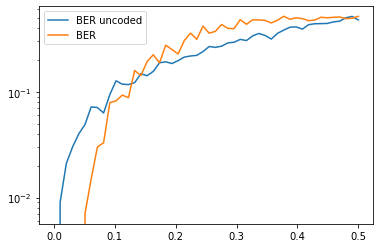

In [12]:
#viterbi decoder vs uncoded
Pe = np.linspace(0,0.5,num=50)
sweep_BER = []
sweep_BER_uncoded = []
for i in Pe:    
    #coded
    d_in_hat = BSC(d_in,Pe=i)
    u_hat = conv_dec(d_in_hat,state_table)
    sweep_BER.append( BER(u,u_hat) )
    #uncoded
    u_hat_uncoded =  BSC(u,Pe=i)
    sweep_BER_uncoded.append(BER(u,u_hat_uncoded))
plt.plot(Pe,sweep_BER_uncoded,label="BER uncoded")
plt.plot(Pe,sweep_BER,label="BER")
plt.yscale('log')
plt.legend()

In [13]:
#sliding window viterbi test
message_size = 10000
u = np.random.randint(0,2,size=message_size)
g = np.array([[1,1,1], [1,0,1]])
m = 2
d_in = conv_enc(u,g,m)
d_in_hat = BSC(d_in,Pe=0.1)
u_hat = conv_dec_sliding(d_in_hat,state_table,Lc=5*m,debug=True) #5 times the memory element number
BER(u,u_hat)

path_matrix : 
 [[1 3 1 3]
 [0 2 0 2]
 [0 2 0 2]
 [1 3 1 3]
 [0 3 1 3]
 [0 3 1 3]
 [0 2 1 2]
 [0 2 1 2]
 [0 3 0 2]
 [1 2 1 3]] 
accumulative metric :  [1828 1828 1828 1826]


0.0716

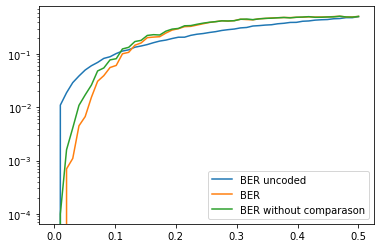

In [14]:
#sliding window viterbi v1, v2 vs uncoded, sweep error rate
Pe = np.linspace(0,0.5,num=50)
sweep_BER = []
sweep_BER_v2 = []
sweep_BER_uncoded = []
for i in Pe:    
    #coded
    d_in_hat = BSC(d_in,Pe=i)
    u_hat = conv_dec_sliding(d_in_hat,state_table,Lc=5*m)
    sweep_BER.append( BER(u,u_hat) )
    #v2
    u_hat = conv_dec_sliding_v2(d_in_hat,state_table,Lc=5*m)
    sweep_BER_v2.append( BER(u,u_hat) )
    #uncoded
    u_hat_uncoded =  BSC(u,Pe=i)
    sweep_BER_uncoded.append(BER(u,u_hat_uncoded))
plt.plot(Pe,sweep_BER_uncoded,label="BER uncoded")
plt.plot(Pe,sweep_BER,label="BER")
plt.plot(Pe,sweep_BER_v2,label="BER without comparason")
plt.yscale('log')
plt.legend()

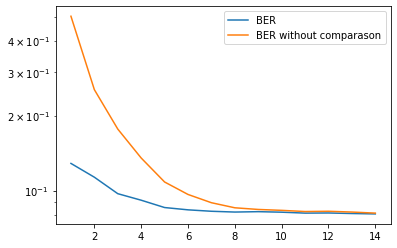

In [17]:
#Comparing different constrain length
message_size = 10000
u = np.random.randint(0,2,size=message_size)
g = np.array([[1,1,1], [1,0,1]])
m = 2
d_in = conv_enc(u,g,m)
d_in_hat = BSC(d_in,Pe=0.1)
Lc = [i for i in range(1,15)]
sweep_Lc_BER=[]
sweep_Lc_BER_without_compare=[]
for i in Lc:
    Lcc = i*m
    u_hat = conv_dec_sliding(d_in_hat,state_table,Lc=Lcc)
    sweep_Lc_BER.append( BER(u,u_hat) )
    u_hat = conv_dec_sliding_v2(d_in_hat,state_table,Lc=Lcc)
    sweep_Lc_BER_without_compare.append( BER(u,u_hat) )
plt.plot(Lc,sweep_Lc_BER,label="BER")
plt.plot(Lc,sweep_Lc_BER_without_compare,label="BER without comparason")
plt.yscale('log')
plt.legend()